In [107]:
!pip install folium
!pip install geopandas
!pip install contextily
!pip install colormaps

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import folium
import random 

import geopandas as gpd
import contextily as ctx

import networkx as nx
from matplotlib import colormaps
import seaborn as sns

In [128]:
passagers = pd.read_csv("../data_chall_alstom/passagers.csv")
print(passagers.info())
plan_metro = pd.read_csv("../data_chall_alstom/plan_du_métro.csv")
print(plan_metro.info())
position_gps = pd.read_csv("../data_chall_alstom/position_gps_des_stations_de_métro_cleaned.csv")
print(position_gps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      980 non-null    object
 1   de Station    980 non-null    object
 2   vers Ligne    980 non-null    object
 3   vers Station  980 non-null    object
dtypes: object(4)
memory usage: 30.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  307 non-null    object
 1   GPS      307 non-null    object
dty

### Mis en forme des jeu de données

In [129]:
plan_metro_ligne = plan_metro[plan_metro["de Station"]!=plan_metro["vers Station"]]
position_gps['lat'], position_gps['lng'] = zip(*position_gps['GPS'].apply(lambda x: x.split(',')))

In [130]:
stations=[]
"""
ligne_nb = list(range(1,15))
ligne_nb=[chr(x) for x in ligne_nb]
ligne_nb.append("3bis")
ligne_nb.append("7bis")
"""
ligne_nb=["1","2","3","3bis","4","5","6","7","8","9","10","11","12","13","14","7bis"]

for ligne in ligne_nb :
    liste_coord=[]
    df_lignei=plan_metro_ligne[plan_metro_ligne["de Ligne"]==ligne]
    station = df_lignei["de Station"].unique()

    for st in station:
        if not(position_gps[position_gps['Station']==st].empty):
            liste_coord.append([float(position_gps[position_gps['Station']==st].iat[0,3]), float(position_gps[position_gps['Station']==st].iat[0,2])])

    
    stations.append({'coordinates' : liste_coord, 'type': 'LineString'})

plan_ligne = pd.DataFrame()
plan_ligne["ligne"] = ligne_nb
plan_ligne["station"] = stations

### Representation graphique du reseau

In [131]:
ligne_1=plan_ligne.loc[7]
idf_map = folium.Map(location=[48.868, 2.365], zoom_start=12, tiles='Cartodb dark_matter')


for segment in plan_ligne["station"]:
    gjson = folium.features.GeoJson(segment,
                                    style_function = lambda x: {'color': '#ED6852',
                                                                'weight': 1.5})
    idf_map.add_child(gjson)


for i, v in position_gps.iterrows():
    folium.CircleMarker(location=[v['lat'], v['lng']],
                        radius=1.2,
                        color='#FFFFF0',
                        fill_color='#FFFFFF',
                        fill=True).add_to(idf_map)
idf_map

### Creation de la matrice

In [132]:
import math

#On calcule la distance avec la formule de Haversine
def calcul_distance(station1, station2):
    coord_station1 = position_gps.loc[position_gps["Station"] == station1, "GPS"].iloc[0]
    coord_station2 = position_gps.loc[position_gps["Station"] == station2, "GPS"].iloc[0]
    lat1 , lon1 = map(float, coord_station1.split(", "))
    lat2 , lon2 = map(float, coord_station2.split(", "))
    # Rayon de la Terre en kilomètres
    R = 6371.0
    
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Différences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Distance
    distance = R * c
    return distance

def calcul_temps(station1,station2,vitesse):
    return round(calcul_distance(station1,station2)/vitesse*3600)

In [133]:
def creation_matrice(plan_metro, position):
    plan_metro_grouped = plan_metro.groupby("de Station")
    passagers_dict = passagers.set_index(["de", "vers"])["nombre"].to_dict()

    # Liste unique des stations
    liste_station = position["Station"].unique()

    # Initialisation d'un dictionnaire pour construire le graph
    graph_dict = {station: [] for station in liste_station}

    # Construction optimisée du graph
    for depuis in liste_station:
        lien = plan_metro_grouped.get_group(depuis)["vers Station"].unique() if depuis in plan_metro_grouped.groups else []

        # Créer une liste pour chaque station de départ
        for vers in liste_station:
            noeud = {
                "ligne": [],
                "passager": passagers_dict.get((depuis, vers), 0) if depuis != vers else 0
            }

            if vers in lien:
                noeud["ligne"] = list(plan_metro[
                    (plan_metro["de Station"] == depuis) & 
                    (plan_metro["vers Station"] == vers)
                ]["de Ligne"].unique())

            graph_dict[depuis].append(noeud)

    # Conversion en DataFrame
    graph = pd.DataFrame(graph_dict, index=liste_station)
    return graph


In [134]:
df=creation_matrice(plan_metro, position_gps)

In [135]:
# Option pour afficher toutes les lignes
pd.set_option('display.max_rows', None)

# Option pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher le DataFrame en entier
print(df['Olympiades'])
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

Boucicaut                                      {'ligne': [], 'passager': 3}
Bourse                                         {'ligne': [], 'passager': 3}
Bir-Hakeim                                     {'ligne': [], 'passager': 4}
Argentine                                      {'ligne': [], 'passager': 6}
Daumesnil                                      {'ligne': [], 'passager': 8}
Église d'Auteuil                               {'ligne': [], 'passager': 7}
George V                                       {'ligne': [], 'passager': 6}
Franklin D. Roosevelt                          {'ligne': [], 'passager': 4}
Europe                                         {'ligne': [], 'passager': 7}
Jacques Bonsergent                             {'ligne': [], 'passager': 8}
Jussieu                                        {'ligne': [], 'passager': 6}
Miromesnil                                     {'ligne': [], 'passager': 9}
Liberté                                        {'ligne': [], 'passager': 2}
Louise Miche

In [136]:
def creation_graphe(matrice):
    # Création du graphe avec NetworkX à partir du DataFrame
    G = nx.DiGraph()

    # Ajouter des arêtes au graphe en utilisant les informations du DataFrame
    for start_station in matrice.index:
        for end_station in matrice.columns:
            connection = matrice.loc[start_station, end_station]
            if connection['ligne']!=[] and start_station != end_station:
                G.add_edge(start_station, end_station,
                        lines=connection['ligne'],
                        passagers=connection["passager"])
    # Visualisation (optionnel)
    for i, node in position_gps.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"]))) 
    return G

In [137]:
G_metro = creation_graphe(df)

In [138]:
G_metro.number_of_edges()

724

In [139]:
nx.is_strongly_connected(G_metro)

True

In [140]:
def afficher_graph(G_metro):
    # Récupérer les positions des nœuds pour NetworkX
    pos=nx.get_node_attributes(G_metro, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([position[0] for position in pos.values()], [position[1] for position in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passagers"] for _, _, data in G_metro.edges(data=True)]
    norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
    cmap = colormaps["plasma"]
    edge_colors = [cmap(norm(data["passagers"])) for _, _, data in G_metro.edges(data=True)]

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G_metro,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()

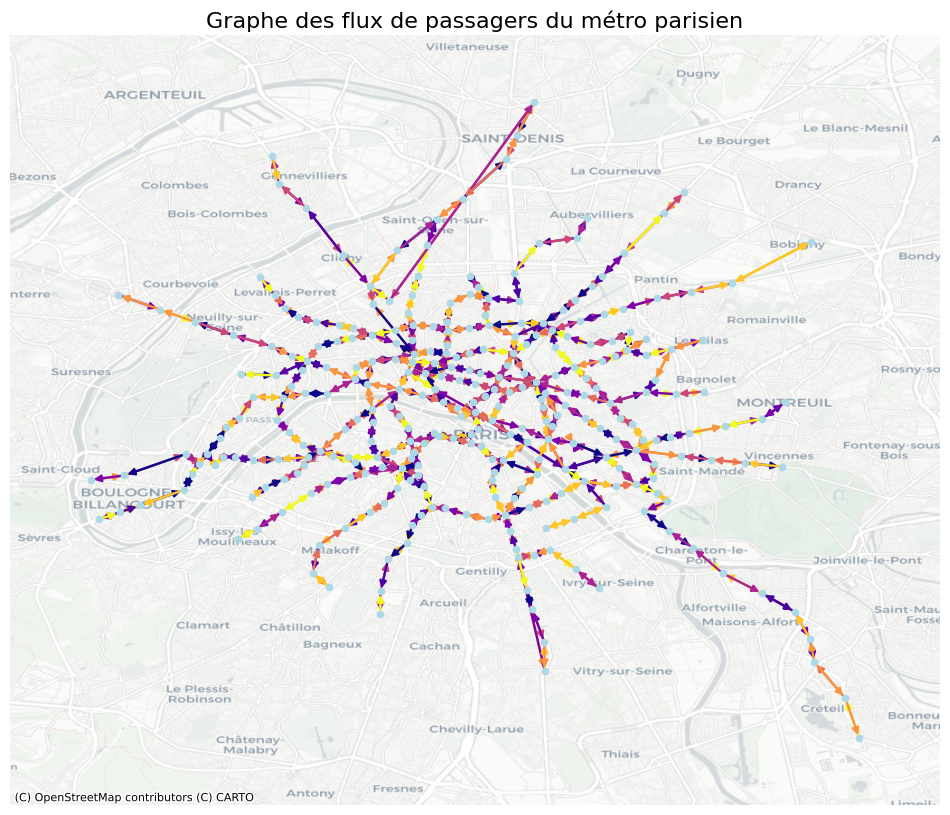

In [141]:
afficher_graph(G_metro)

In [142]:
from collections import defaultdict

def calculer_flux_passagers(graphe, donnees):
    """
    Calcule le flux de passagers à travers un graphe en fonction des données de trajet.
    Chaque flux directionnel est traité séparément sans addition dans l'autre sens.
    
    :param graphe: Graph NetworkX représentant le réseau de transport.
    :param donnees: Liste de tuples (gare_depart, gare_arrivee, nombre_passagers).
    :return: Deux dictionnaires contenant les flux par nœud et par arête.
    """
    # Initialisation des flux
    flux_par_noeud = defaultdict(int)
    flux_par_arete = defaultdict(int)

    # Calcul des trajets pour chaque donnée
    for gare_depart, gare_arrivee, nombre_passagers in donnees:
        try:
            # Trouver le chemin le plus court
            chemin = nx.shortest_path(graphe, source=gare_depart, target=gare_arrivee)
            
            # Ajouter les passagers à chaque nœud et arête du chemin
            for i in range(len(chemin)):
                # Ajouter au flux du nœud
                flux_par_noeud[chemin[i]] += nombre_passagers
                if i < len(chemin) - 1:
                    # Ajouter au flux de l'arête (en gardant la direction distincte)
                    u, v = chemin[i], chemin[i + 1]
                    flux_par_arete[(u, v)] += nombre_passagers
        except nx.NetworkXNoPath:
            pass
            #print(f"Pas de chemin entre {gare_depart} et {gare_arrivee}.")

    # Créer une matrice d'adjacence sous forme de DataFrame
    noeuds = list(graphe.nodes)
    matrice_flux = pd.DataFrame(0, index=noeuds, columns=noeuds)

    # Remplir la matrice avec les flux
    for (u, v), flux in flux_par_arete.items():
        matrice_flux.loc[u, v] = flux
    return flux_par_noeud, matrice_flux

In [143]:
"""
# Exemple d'utilisation
if __name__ == "__main__":
   
   
    donnees = list(passagers_filtre[['de', 'vers', 'nombre']].itertuples(index=False, name=None))

    # Calcul des flux
    flux_noeuds, flux_aretes = calculer_flux_passagers(G_metro, donnees)

    # Afficher les résultats
    #print("Flux par nœud :")
    #for noeud, flux in flux_noeuds.items():
    #    print(f"{noeud} : {flux}")
#
    #print("\nFlux par arête :")
    #for arete, flux in flux_aretes.items():
    #    print(f"{arete} : {flux}")

# Convertir les résultats en DataFrame
flux_noeuds_df = pd.DataFrame(list(flux_noeuds.items()), columns=['Noeud', 'Flux'])
flux_aretes_df = pd.DataFrame(list(flux_aretes.items()), columns=['Arete', 'Flux'])

# Ajouter des colonnes pour les nœuds de départ et d'arrivée dans le DataFrame des arêtes
flux_aretes_df[['Noeud_depart', 'Noeud_arrivee']] = pd.DataFrame(flux_aretes_df['Arete'].tolist(), index=flux_aretes_df.index)
flux_aretes_df = flux_aretes_df.drop(columns=['Arete'])

# Enregistrer les DataFrames dans des fichiers CSV
flux_noeuds_df.to_csv("flux_par_noeud.csv", index=False, encoding="utf-8")
flux_aretes_df.to_csv("flux_par_arete.csv", index=False, encoding="utf-8") 
"""

'\n# Exemple d\'utilisation\nif __name__ == "__main__":\n   \n   \n    donnees = list(passagers_filtre[[\'de\', \'vers\', \'nombre\']].itertuples(index=False, name=None))\n\n    # Calcul des flux\n    flux_noeuds, flux_aretes = calculer_flux_passagers(G_metro, donnees)\n\n    # Afficher les résultats\n    #print("Flux par nœud :")\n    #for noeud, flux in flux_noeuds.items():\n    #    print(f"{noeud} : {flux}")\n#\n    #print("\nFlux par arête :")\n    #for arete, flux in flux_aretes.items():\n    #    print(f"{arete} : {flux}")\n\n# Convertir les résultats en DataFrame\nflux_noeuds_df = pd.DataFrame(list(flux_noeuds.items()), columns=[\'Noeud\', \'Flux\'])\nflux_aretes_df = pd.DataFrame(list(flux_aretes.items()), columns=[\'Arete\', \'Flux\'])\n\n# Ajouter des colonnes pour les nœuds de départ et d\'arrivée dans le DataFrame des arêtes\nflux_aretes_df[[\'Noeud_depart\', \'Noeud_arrivee\']] = pd.DataFrame(flux_aretes_df[\'Arete\'].tolist(), index=flux_aretes_df.index)\nflux_aretes_df 

In [144]:
donnees = list(passagers[['de', 'vers', 'nombre']].itertuples(index=False, name=None))
flux_noeuds, matrice_flux_reseau_parfait = calculer_flux_passagers(G_metro, donnees)

In [145]:
matrice_flux_reseau_parfait

Boucicaut  Félix Faure  Lourmel  Bourse   
Boucicaut                             0         4603     2980       0  \
Félix Faure                        4478            0        0       0   
Lourmel                            3108            0        0       0   
Bourse                                0            0        0       0   
Sentier                               0            0        0    1761   
...                                 ...          ...      ...     ...   
Malakoff - Rue Étienne-Dolet          0            0        0       0   
Faidherbe - Chaligny                  0            0        0       0   
Châtillon - Montrouge                 0            0        0       0   
Créteil - L'Échat                     0            0        0       0   
Créteil - Université                  0            0        0       0   

                              Sentier  Quatre-Septembre  Bir-Hakeim  Passy   
Boucicaut                           0                 0           0      0  \
Félix Faure                         0                 0           0      0   
Lourmel                             0                 0           0      0   
Bourse                           1642              2531           0      0   
Sentier                             0                 0           0      0   
...                               ...               ...         ...    ...   
Malakoff - Rue Étienne-Dolet        0                 0           0      0   
Faidherbe - Chaligny                0                 0           0      0   
Châtillon - Montrouge               0                 0           0      0   
Créteil - L'Échat                   0                 0           0      0   
Créteil - Université                0                 0           0      0   

                              Dupleix  Argentine  ...  Porte de la Chapelle   
Boucicaut                           0          0  ...                     0  \
Félix Faure                         0          0  ...                     0   
Lourmel                             0          0  ...                     0   
Bourse                              0          0  ...                     0   
Sentier                             0          0  ...                     0   
...                               ...        ...  ...                   ...   
Malakoff - Rue Étienne-Dolet        0          0  ...                     0   
Faidherbe - Chaligny                0          0  ...                     0   
Châtillon - Montrouge               0          0  ...                     0   
Créteil - L'Échat                   0          0  ...                     0   
Créteil - Université                0          0  ...                     0   

                              Marx Dormoy  Château Rouge  Pont de Sèvres   
Boucicaut                               0              0               0  \
Félix Faure                             0              0               0   
Lourmel                                 0              0               0   
Bourse                                  0              0               0   
Sentier                                 0              0               0   
...                                   ...            ...             ...   
Malakoff - Rue Étienne-Dolet            0              0               0   
Faidherbe - Chaligny                    0              0               0   
Châtillon - Montrouge                   0              0               0   
Créteil - L'Échat                       0              0               0   
Créteil - Université                    0              0               0   

                              Avenue Émile-Zola  Malakoff - Rue Étienne-Dolet   
Boucicaut                                     0                             0  \
Félix Faure                                   0                             0   
Lourmel                                       0                             0   
Bourse                        

In [146]:
def graph_flux(matrice_flux, positions):

    G = nx.DiGraph()

    # Remplir le graphe avec les flux directionnels
    for u in matrice_flux.index:
        for v in matrice_flux.columns:
            flux = matrice_flux.loc[u, v]
            if flux > 0:  # Ajouter uniquement les relations avec un flux positif
                G.add_edge(u, v, passager=flux)

    # Ajouter les positions des stations
    for _, node in positions.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"])))

    # Récupérer les positions des nœuds pour NetworkX
    pos = nx.get_node_attributes(G, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([p[0] for p in pos.values()], [p[1] for p in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passager"] for _, _, data in G.edges(data=True)]
    if passager_values:  # Vérifier qu'il y a des valeurs pour normaliser
        norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
        cmap = colormaps["plasma"]
        edge_colors = [cmap(norm(data["passager"])) for _, _, data in G.edges(data=True)]
    else:
        edge_colors = []  # Pas de flux

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        connectionstyle="arc3,rad=-0.1",
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()

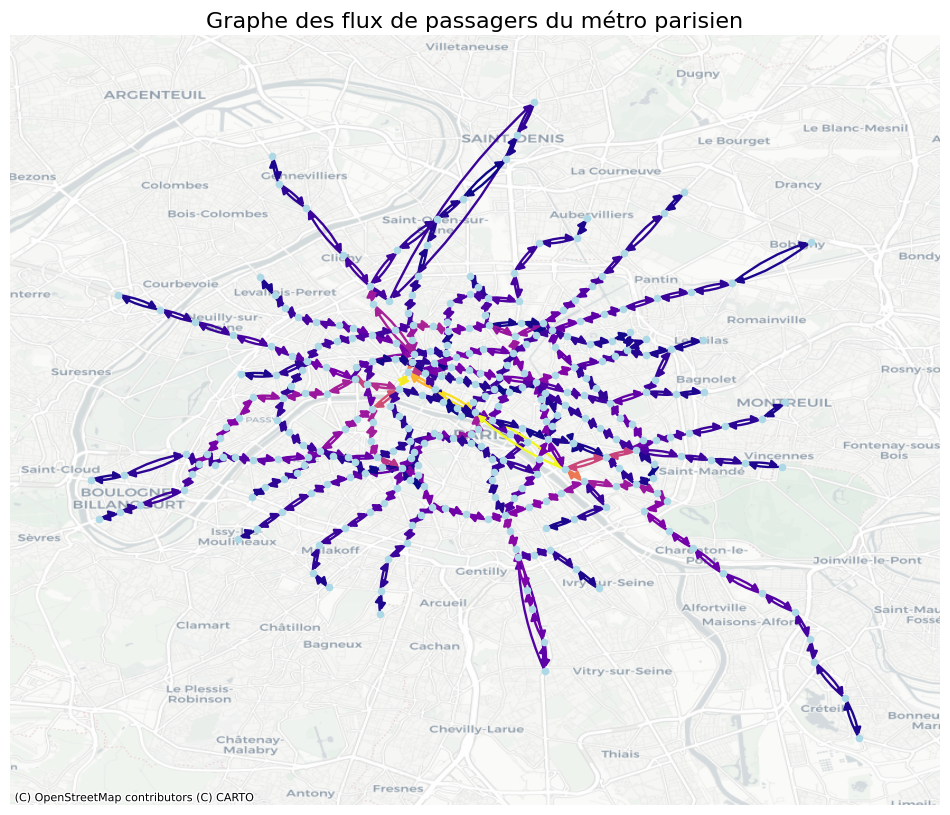

In [147]:
graph_flux(matrice_flux_reseau_parfait, position_gps)

In [148]:
plan_metro.iloc[232]

de Ligne                              1
de Station      Esplanade de La Défense
vers Ligne                            1
vers Station                 La Défense
Name: 232, dtype: object

In [149]:
df_ligne_insuppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])
df_ligne_suppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])

In [150]:
compteur = 0
for index, row in plan_metro.iterrows(): 
    G_metro_test=G_metro   
    stationDe = row['de Station']
    stationVers = row['vers Station']
    if stationDe != stationVers: 
        # Supprimer temporairement l'arête
        G_metro_test.remove_edge(stationDe, stationVers)
        # Vérifier si le graphe reste connexe
        if nx.is_strongly_connected(G_metro_test):
            compteur += 1
            df_ligne_suppressible.loc[len(df_ligne_suppressible)] = row
        else:
            df_ligne_insuppressible.loc[len(df_ligne_insuppressible)] = row
        G_metro_test.add_edge(stationDe, stationVers)
    else :
        df_ligne_insuppressible.loc[len(df_ligne_insuppressible)]=row
print('Nb_arete suppressible:',compteur)

Nb_arete suppressible: 520


In [151]:
print(len(df_ligne_insuppressible))
print(len(df_ligne_suppressible))

460
520


In [152]:
# Option pour afficher toutes les lignes
pd.set_option('display.max_rows', None)

# Option pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher le DataFrame en entier
print(df_ligne_insuppressible)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

    de Ligne                               de Station vers Ligne   
0          1               Charles de Gaulle - Étoile          2  \
1          1               Charles de Gaulle - Étoile          6   
2          1                    Franklin D. Roosevelt          9   
3          1              Champs-Élysées - Clemenceau         13   
4          1                                 Concorde          8   
5          1                                 Concorde         12   
6          1           Palais-Royal - Musée du Louvre          7   
7          1                                 Châtelet          4   
8          1                                 Châtelet          7   
9          1                                 Châtelet         11   
10         1                                 Châtelet         14   
11         1                           Hôtel de Ville         11   
12         1                                 Bastille          5   
13         1                                 Bas

In [153]:
def generate_one_problem():
    # Étape 1 : Nombre aléatoire de lignes cassées à simuler
    nb_lignes_cassees = random.randint(1,50)
    ##nb_lignes_cassees = random.randint(1, df_ligne_suppressible)

    lignes_cassees = df_ligne_suppressible.sample(nb_lignes_cassees)

    # Étape 3 : Créer le DataFrame final
    lignes_restantes = pd.concat([df_ligne_suppressible, lignes_cassees]).drop_duplicates(keep=False)

    # Combiner avec les lignes insuppressibles
    df_final = pd.concat([df_ligne_insuppressible, lignes_restantes], ignore_index=True)
    return df_final

In [154]:
def faire_matrice_flux(matrice_graphe,matrice_flux_origine):
    graphe = creation_graphe(matrice_graphe)
    _ , matrice_nouveau_flux = calculer_flux_passagers(graphe, donnees)
    # Calcul de la variation en pourcentage
    variation_flux = (matrice_nouveau_flux - matrice_flux_origine) / matrice_flux_origine * 100
    
    # Gérer les cas où matrice_flux_origine a des zéros pour éviter les divisions par zéro
    variation_flux = variation_flux.fillna(0)  # Remplace NaN par 0 dans les cas où origine = 0
    return variation_flux

In [155]:
variation_flux = faire_matrice_flux(creation_matrice(generate_one_problem(),position_gps),matrice_flux_reseau_parfait)

In [156]:
# Option pour afficher toutes les lignes
pd.set_option('display.max_rows', None)

# Option pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher le DataFrame en entier
print(variation_flux)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                                          Abbesses  Aimé Césaire   
Abbesses                                  0.000000      0.000000  \
Aimé Césaire                              0.000000      0.000000   
Alexandre Dumas                           0.000000      0.000000   
Alma - Marceau                            0.000000      0.000000   
Alésia                                    0.000000      0.000000   
Anatole France                            0.000000      0.000000   
Anvers                                    0.000000      0.000000   
Argentine                                 0.000000      0.000000   
Arts et Métiers                           0.000000      0.000000   
Assemblée nationale                       0.000000      0.000000   
Aubervilliers - Pantin - Quatre Chemins   0.000000      0.000000   
Avenue Émile-Zola                         0.000000      0.000000   
Avron                                     0.000000      0.000000   
Bagneux - Lucie Aubrac                    0.0000

In [207]:
def generate_train_dataset(n):
    train_dataset = []
    for i in range (n):
        graph_generer=creation_matrice(generate_one_problem(),position_gps)
        while nx.is_strongly_connected(creation_graphe(graph_generer))==False:
            graph_generer=creation_matrice(generate_one_problem(),position_gps)
        print(i,"/",n)
        train_dataset.append((creation_graphe(graph_generer),faire_matrice_flux(graph_generer,matrice_flux_reseau_parfait)))
    return train_dataset

In [318]:
dataset_train1 = generate_train_dataset(200)

0 / 200
1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200
95 / 200
96 / 200
97 / 200
98 / 200
99 / 200
100 / 200
101 / 200
102 / 200
103 / 200
104 / 200
105 / 200
106 / 200
107 / 200
108 / 200
109 / 200
110 / 200


In [319]:
pd.DataFrame(dataset_train1, columns=["plan_metro_degradé", "flux_dégradé"]).to_pickle('dataset_train_200.pkl')

In [ ]:

data = dataset_train1[0][1]

# Récupérer les valeurs différentes de 0 avec leurs indices et colonnes
result = data.stack().loc[lambda x: x > 20]

# Affichage du résultat
result_list = [((idx, col), val) for (idx, col), val in result.items()]


In [306]:
n=100
data = dataset_train1[0][1]
# Récupérer les valeurs différentes de 0 avec leurs indices et colonnes
result = data.stack()

# Affichage du résultat
result_list = [((idx, col), val) for (idx, col), val in result.items()]
df_degradation_moyenne = pd.DataFrame(result_list, columns=["Liaison", "Dégradation"])
df_degradation_moyenne["Dégradation"]=df_degradation_moyenne["Dégradation"]/100

for i in range(1,n):

    data = dataset_train1[i][1]
    # Récupérer les valeurs différentes de 0 avec leurs indices et colonnes
    result = data.stack()
    
    # Affichage du résultat
    result_list = [((idx, col), val) for (idx, col), val in result.items()]
    df = pd.DataFrame(result_list, columns=["Liaison", "Dégradation"])
    df_degradation_moyenne["Dégradation"]=df_degradation_moyenne["Dégradation"]+(df["Dégradation"]/n)

print(df_degradation_moyenne.describe())

        Dégradation
count  94249.000000
mean       0.092896
std        3.178060
min      -12.643373
25%        0.000000
50%        0.000000
75%        0.000000
max      393.180812


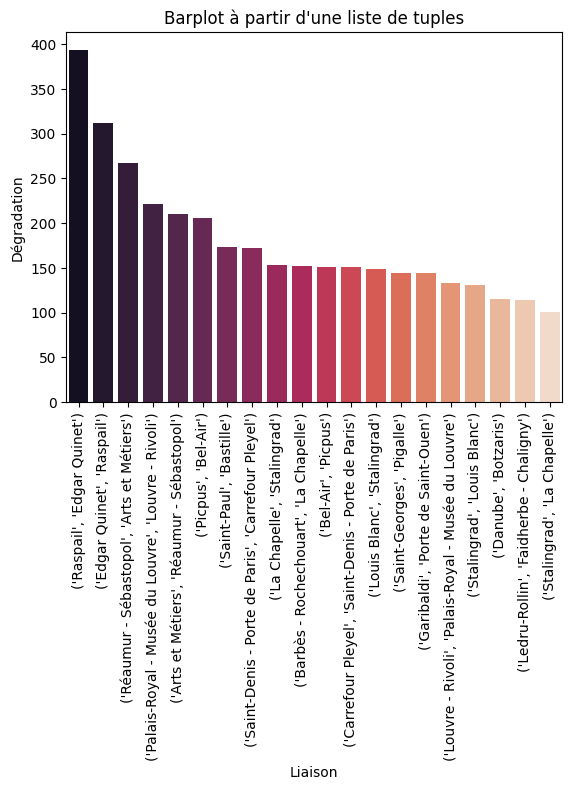

In [311]:
df_degradation_moyenne=df_degradation_moyenne.sort_values("Dégradation", ascending=False)

sns.barplot(x="Liaison", y="Dégradation", data=df_degradation_moyenne.head(20), palette="rocket")

# Ajouter un titre
plt.title("Barplot à partir d'une liste de tuples")
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()

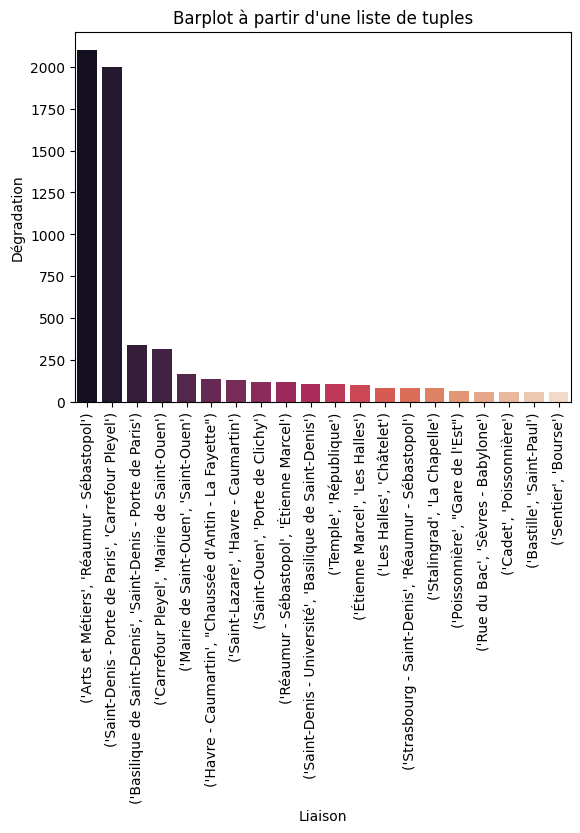

In [314]:
#Rajouter un second graph avec tail au lieu de head

data = dataset_train1[0][1]

# Récupérer les valeurs différentes de 0 avec leurs indices et colonnes
result = data.stack().loc[lambda x: np.abs(x) > 20]

# Affichage du résultat
result_list = [((idx, col), val) for (idx, col), val in result.items()]

# Convertir la liste de tuples en DataFrame
df = pd.DataFrame(result_list, columns=["Liaison", "Dégradation"]).sort_values("Dégradation", ascending = False)

# Créer le barplot avec Seaborn
sns.barplot(x="Liaison", y="Dégradation", data=df.head(20), palette="rocket")

# Ajouter un titre
plt.title("Barplot à partir d'une liste de tuples")
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()